In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
color_pal=sns.color_palette()

## Data Source
All data are obtained from PJM Website's Data Miner \
Demand data comes from Hourly Load: Metered PJM Data \
Price data comes from Real-Time Five Minute LMPs \
CSV files are aggregated by month. The inquiry date format is 1/1 0:00 to 1/31 23:59

## Data Cleaning

In [2]:
# Function to read all CSV files in a folder and concatenate them into a single DataFrame
def concatenate_csv_from_folder(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Initialize an empty list to hold the DataFrames
    df_list = []
    
    # Loop through the CSV files and read each one into a DataFrame
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        # Explicitly parse the datetime columns with a specific format
        df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')
        df['datetime_beginning_utc'] = pd.to_datetime(df['datetime_beginning_utc'], format='%m/%d/%Y %I:%M:%S %p')
        
        df_list.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Function to visualize missing dates in a dataframe
def visualize_missing_dates(df, df_name):
    # Extract the unique dates from the 'datetime_beginning_ept' column
    df['date_only'] = df['datetime_beginning_ept'].dt.date
    unique_dates = pd.to_datetime(df['date_only'].unique())
    
    # Create a full date range from the minimum to the maximum date
    full_date_range = pd.date_range(start=unique_dates.min(), end=unique_dates.max())
    
    # Mark presence (True) or absence (False) of each date in the full date range
    presence = full_date_range.isin(unique_dates)
    
    # Plot the presence or absence of dates
    plt.figure(figsize=(10, 4))
    plt.bar(full_date_range, presence, color=['green' if p else 'red' for p in presence], width=1)
    
    plt.title(f'Date Presence in {df_name}')
    plt.xlabel('Date')
    plt.ylabel('Presence (1 = Present, 0 = Missing)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

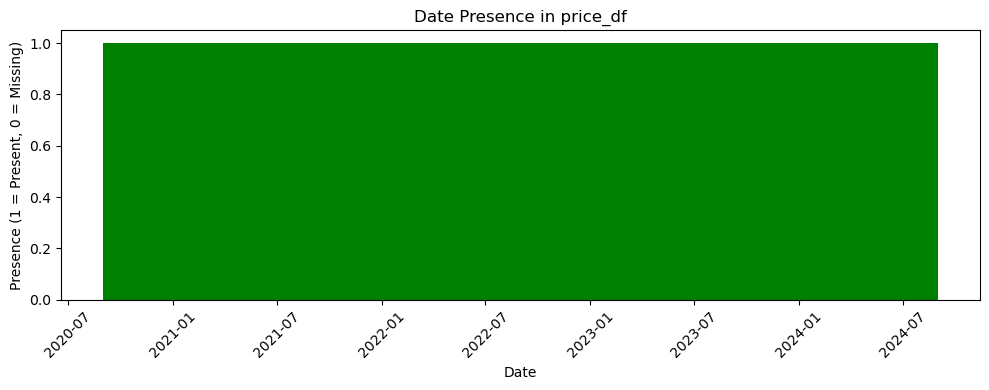

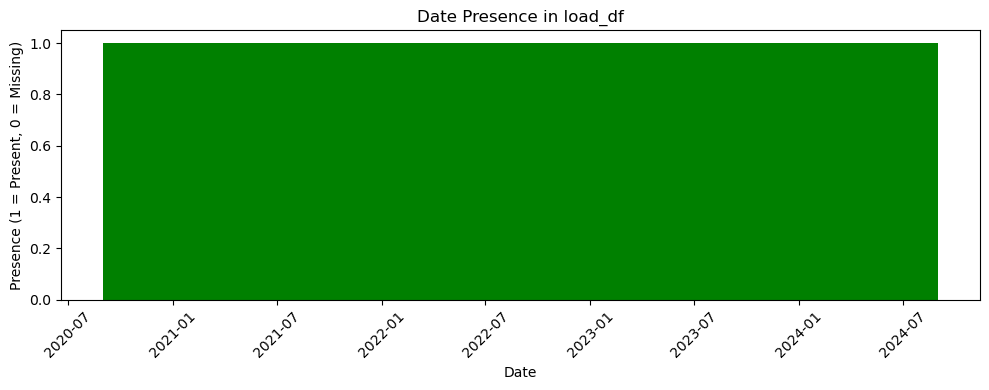

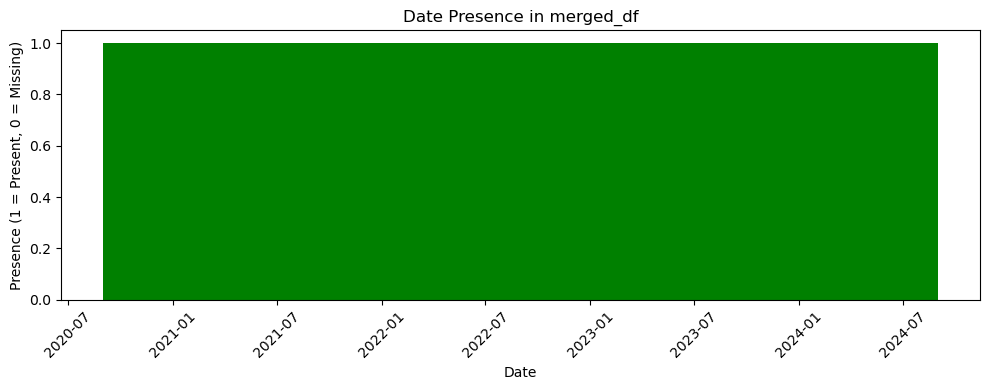

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [3]:
# Define the folder paths
settlement_folder = 'PJM_Settlement_Verified_Hourly_LMP'
load_folder = 'PJM_Hourly_Load_Metered'

# Concatenate the CSV files from each folder
price_df = concatenate_csv_from_folder(settlement_folder)
price_df = price_df[["datetime_beginning_ept","pnode_name","type","total_lmp_rt"]]

load_df = concatenate_csv_from_folder(load_folder)
load_df = load_df[["datetime_beginning_ept","mkt_region","zone","load_area","mw"]]

#COMED is abbreviated CE in load dataframe but COMED in price dataframe
load_df['zone'] = load_df['zone'].replace('CE', 'COMED')

# Filter price_df to only keep rows where 'type' is 'ZONE'
price_df_filtered = price_df[price_df['type'] == 'ZONE']

# Perform an inner join on 'load_area' and 'datetime_beginning_ept'
merged_df = pd.merge(price_df_filtered, load_df, how='inner', 
                     left_on=['pnode_name', 'datetime_beginning_ept'], 
                     right_on=['zone', 'datetime_beginning_ept'])

merged_df["date"] = merged_df['datetime_beginning_ept'].dt.date

#Check data integrity
visualize_missing_dates(price_df, 'price_df')
visualize_missing_dates(load_df, 'load_df')
visualize_missing_dates(merged_df, 'merged_df')

#Check for missing days
load_df['datetime_beginning_ept'] = pd.to_datetime(load_df['datetime_beginning_ept'])
expected_days = pd.date_range(start=load_df['datetime_beginning_ept'].min(),
                               end=load_df['datetime_beginning_ept'].max(),
                               freq='D')
missing_days = expected_days.difference(load_df['datetime_beginning_ept'])

# Print out the missing hours
missing_days

In [6]:
# Filter the merged_df for a specific Zone
zone = "COMED"
zone_df = merged_df[merged_df["pnode_name"] == zone].copy()

# Function to calculate load-weighted average of total_lmp_rt
def calculate_load_weighted_avg(group):
    weighted_sum = (group['total_lmp_rt'] * group['mw']).sum()
    total_load = group['mw'].sum()
    return weighted_sum / total_load if total_load != 0 else 0  # Avoid division by zero

# Group by 'date' and calculate both load sum and load-weighted average price using apply()
unfiltered_daily_load = zone_df.groupby('date').apply(
    lambda group: pd.Series({
        'load': group['mw'].sum(),  # Sum the load
        'price': calculate_load_weighted_avg(group)    # Calculate the weighted average price
    })
).reset_index()
unfiltered_daily_load=unfiltered_daily_load.set_index("date")
unfiltered_daily_load.index=pd.to_datetime(unfiltered_daily_load.index)

## Inspection of Data
Commodity prices often exhibit high kurtosis and fat tailedness. \
This can be attributed to price spikes. As we can see below, the price data does show high skewness and kurtosis

In [8]:
summary_stats = unfiltered_daily_load['price'].describe()

# Calculate skewness for the 'price' column
price_skewness = skew(unfiltered_daily_load['price'])

# Calculate kurtosis for the 'price' column
price_kurtosis = kurtosis(unfiltered_daily_load['price'], fisher=False)  # fisher=False returns Pearson's kurtosis

# Print the results
print("Summary Statistics for 'price':\n", summary_stats)
print("\nSkewness of 'price':", price_skewness)
print("\nKurtosis of 'price':", price_kurtosis)

Summary Statistics for 'price':
 count    1461.000000
mean       37.657057
std        33.368735
min        -3.241501
25%        22.047478
50%        30.227513
75%        43.665883
max       718.395938
Name: price, dtype: float64

Skewness of 'price': 10.95970341300132

Kurtosis of 'price': 200.77775861941157


Text(0.5, 1.0, 'Price vs Load Including Outliers')

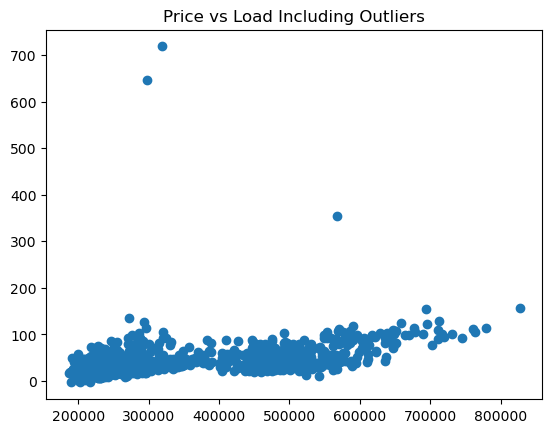

In [9]:
plt.scatter(data=unfiltered_daily_load,x="load",y="price")
plt.title("Price vs Load Including Outliers")

In [13]:
# We see two extreme values with prices above $600
unfiltered_daily_load[unfiltered_daily_load["price"]>300]

,load,price
date,,
2022-06-13,567061.124,353.979221
2022-12-23,319212.145,718.395938
2022-12-24,297964.391,645.464691


## The two outliers occur on December 23 and 24th of 2022.
#This is not an entry error. The high prices can be also seen in the hourly pricing tool\
#https://hourlypricing.comed.com/live-prices/month/?date=20221212 \
#The price spike from the two dates can be attributed to Elliot Winter Storm, which landed in Chicago on these dates.\
#https://acore.org/wp-content/uploads/2023/02/The-Value-of-Transmission-During-Winter-Storm-Elliott-ACORE.pdf \
#Since this is a one time and unpredictable incident, we will exclude these two data points to prevent overfitting

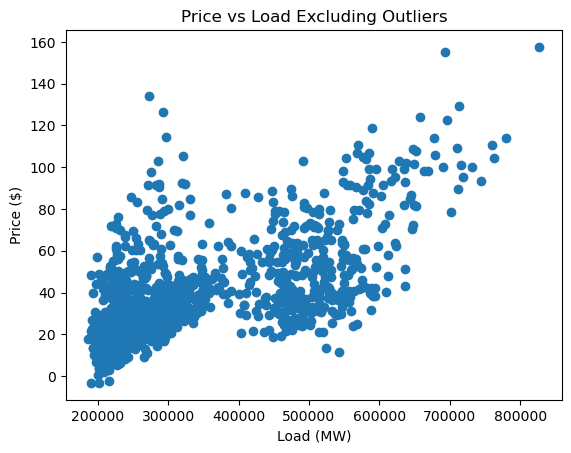

In [14]:
daily_load = unfiltered_daily_load[unfiltered_daily_load["price"]<300]
plt.scatter(data=daily_load,x="load",y="price")
plt.xlabel("Load (MW)")
plt.ylabel("Price ($)")
plt.title("Price vs Load Excluding Outliers")
plt.savefig("Price_Load_Scatter_No_Outlier.png",dpi=500)

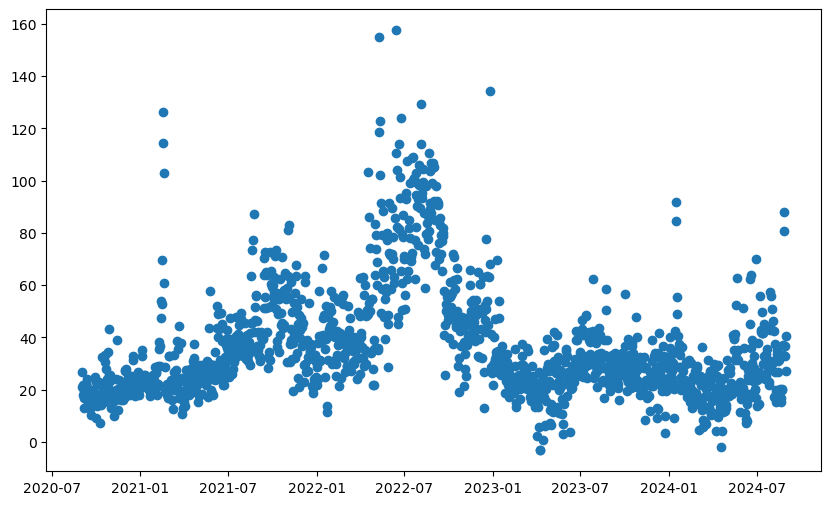

In [15]:
#Plot consumption versus time
plt.figure(figsize=(10,6))
plt.scatter(data = daily_load, x=daily_load.index, y="price")

## Polynomial Regression

In [16]:
# Create the new row as a DataFrame
new_row = pd.DataFrame({
    'load': [800000],
    'price': [350]
}, index=[pd.Timestamp("2020-08-31 00:00:00")])

# Append the new row to the existing daily_load DataFrame
daily_load = pd.concat([daily_load, new_row])

In [17]:
daily_load

,load,price
2020-09-01,278746.439,26.835465
2020-09-02,303625.274,20.836275
2020-09-03,295828.421,18.109187
2020-09-04,252565.603,21.691313
2020-09-05,240300.658,19.341885
...,...,...
2024-08-28,345882.170,32.827995
2024-08-29,337626.478,36.727111
2024-08-30,328743.176,40.522388
2024-08-31,279270.374,27.213510


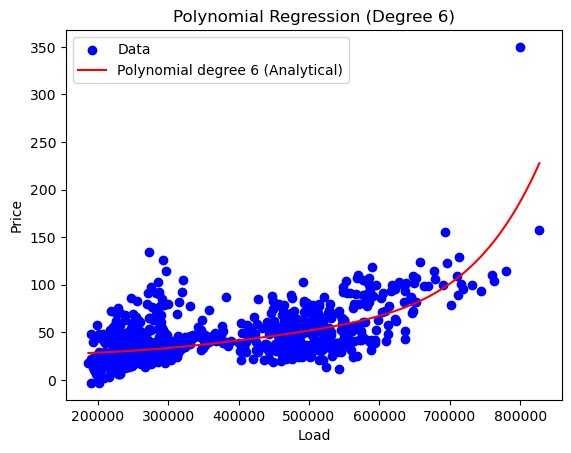

In [18]:
selected_data = daily_load.loc[daily_load.index<'07-01-2023']
X = selected_data["load"].values.reshape(-1, 1)
y = selected_data["price"].values
degree = 6

# Transform features to polynomial features
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
price_load_model = LinearRegression()
price_load_model.fit(X_poly, y)

coefficients = price_load_model.coef_
intercept = price_load_model.intercept_

# Create a function to represent the polynomial model
def polynomial_function(x, coefficients, intercept):
    return sum([coefficients[i] * x**i for i in range(len(coefficients))]) + intercept

# Generate a smooth range of values for plotting the polynomial function
X_range = np.linspace(X.min(), X.max(), 500)
y_analytical = polynomial_function(X_range, coefficients, intercept)

# Plot the actual data and the analytical function
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_range, y_analytical, color='red', label=f'Polynomial degree {degree} (Analytical)')
plt.xlabel('Load')
plt.ylabel('Price')
plt.title(f'Polynomial Regression (Degree {degree})')
plt.legend()
plt.show()

## Exponential Regression

/var/folders/qh/02qn4h550pb6zlgz0lblzwh80000gn/T/ipykernel_50075/963478775.py:5: RuntimeWarning: invalid value encountered in log
  y_log = np.log(y)


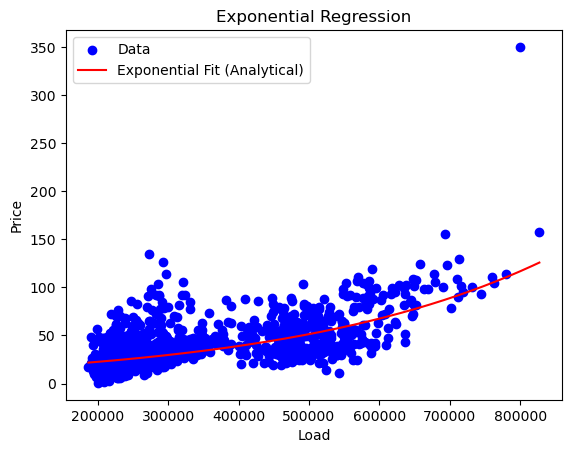

In [19]:
X = daily_load[['load']].values  
y = daily_load['price'].values

# Take the logarithm of y to linearize the exponential model
y_log = np.log(y)

# Create a mask to filter out NaN values from y_log
nan_mask = ~np.isnan(y_log)  # This will be True where y_log is not NaN

# Apply the mask to X and y_log to filter out corresponding NaN rows
X_clean = X[nan_mask]
y_log_clean = y_log[nan_mask]

# Fit a linear regression model to the cleaned data
price_load_model_exp = LinearRegression()
price_load_model_exp.fit(X_clean, y_log_clean)

# Extract the coefficients (slope) and intercept
b = price_load_model_exp.coef_[0]
log_a = price_load_model_exp.intercept_
a = np.exp(log_a)

# Create a function to represent the exponential model
def exponential_function(x, a, b):
    return a * np.exp(b * x)

# Generate a smooth range of values for plotting the exponential function
X_range = np.linspace(X_clean.min(), X_clean.max(), 500)
y_analytical = exponential_function(X_range, a, b)

# Plot the actual data and the analytical function
plt.scatter(X_clean, y[nan_mask], color='blue', label='Data')
plt.plot(X_range, y_analytical, color='red', label='Exponential Fit (Analytical)')
plt.xlabel('Load')
plt.ylabel('Price')
plt.title('Exponential Regression')
plt.legend()
plt.show()

# XGBoost

In [20]:
#Feature Engineering
daily_load['dayofweek']=daily_load.index.dayofweek
daily_load['day']=daily_load.index.day
daily_load['month']=daily_load.index.month
daily_load['quarter']=daily_load.index.quarter
daily_load['year']=daily_load.index.year
daily_load['dayofyear']=daily_load.index.dayofyear

<Axes: xlabel='month', ylabel='load'>

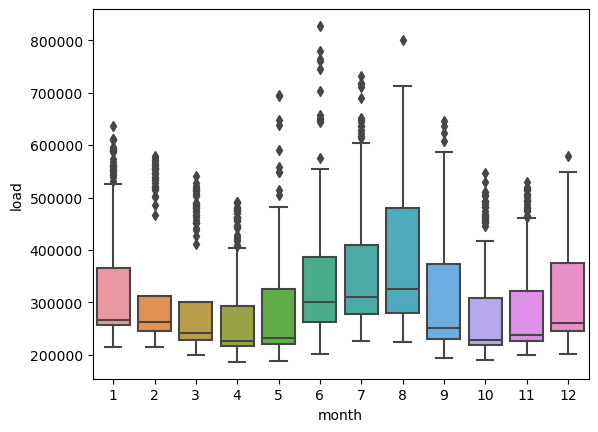

In [21]:
sns.boxplot(data=daily_load,x='month',y='load')

<Axes: xlabel='year', ylabel='load'>

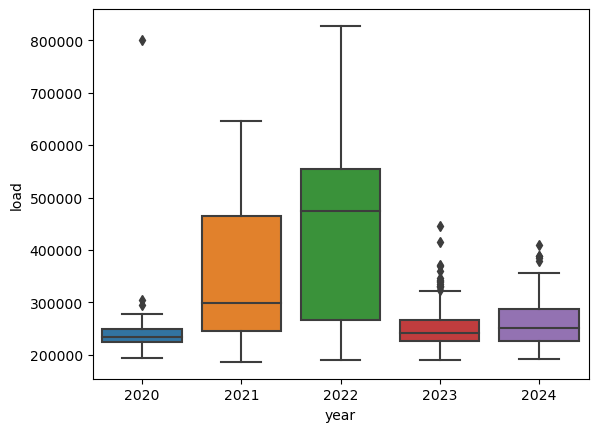

In [22]:
sns.boxplot(data=daily_load,x='year',y='load')

In [23]:
train_time=daily_load.loc[daily_load.index<'07-01-2023']
test_time=daily_load.loc[daily_load.index>='07-01-2023']

x_train=train_time.drop('load',axis=1)
y_train=train_time['load']

x_test=test_time.drop('load',axis=1)
y_test=test_time['load']

In [24]:
demand_model=XGBRegressor(n_estimator=1000)
demand_model.fit(x_train,y_train)

/Users/andrew/miniconda3/envs/quant/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:29:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=1000, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
demand_model.score(x_train,y_train)
testing=demand_model.predict(x_test)
mean_squared_error(testing,y_test)

1425058776.6684434

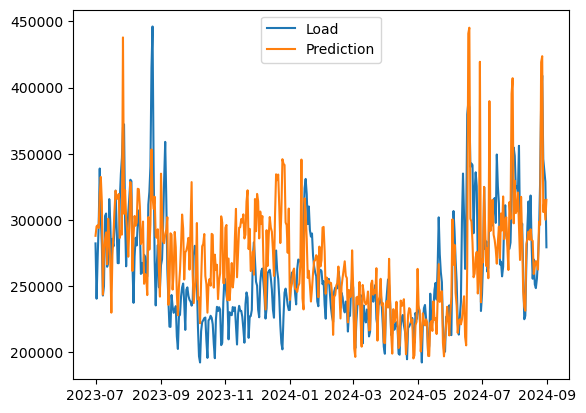

In [26]:
demand_prediction = demand_model.predict(x_test)
visualize = pd.DataFrame(y_test)
visualize["Prediction"] = demand_prediction
plt.plot(visualize, label=["Load","Prediction"])
plt.legend()

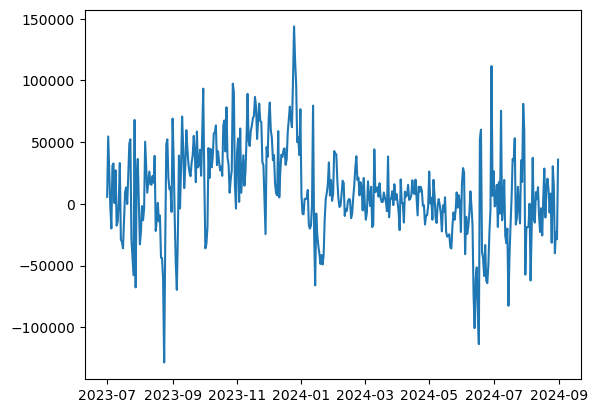

In [28]:
visualize["Difference"] = visualize["Prediction"] - visualize["load"]
plt.plot(visualize["Difference"])

In [29]:
visualize["load"].values.mean()

258869.22308411216

In [30]:
abs(visualize["Difference"].values).mean()

28405.782134637855

## Integrate Price_Load Model and Demand Model

In [31]:
# Assuming 'poly' is the same object used during training
# and 'price_load_model' is already trained

# Step 1: Reshape the demand_prediction array to 2D, as expected by poly.transform
demand_prediction_reshaped = demand_prediction.reshape(-1, 1)

# Step 2: Apply the polynomial transformation using the same poly object
demand_prediction_poly = poly.transform(demand_prediction_reshaped)

# Step 3: Predict using the trained model
price_prediction = price_load_model.predict(demand_prediction_poly)


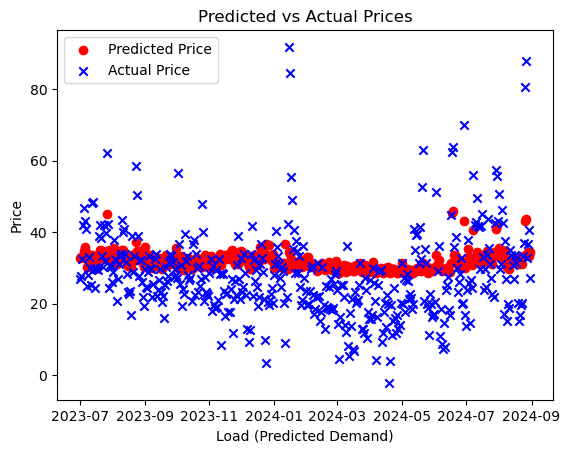

In [32]:
plt.scatter(x_test.index, price_prediction, label='Predicted Price', color='red', marker='o')
plt.scatter(x_test.index, test_time['price'], label='Actual Price', color='blue', marker='x')

# Adding labels and title
plt.xlabel('Load (Predicted Demand)')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')

# Show legend
plt.legend()

# Display the plot

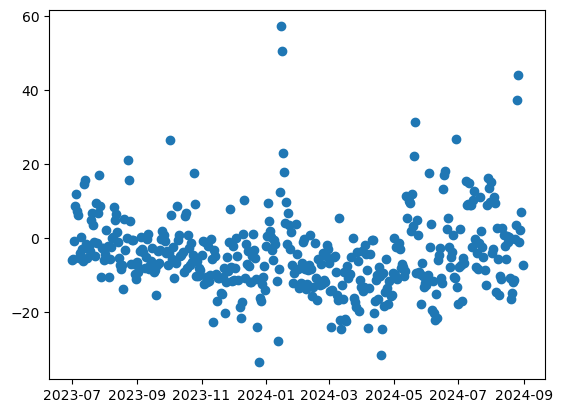

In [33]:
error = test_time["price"] - price_prediction
plt.scatter(x=error.index, y=error.values)

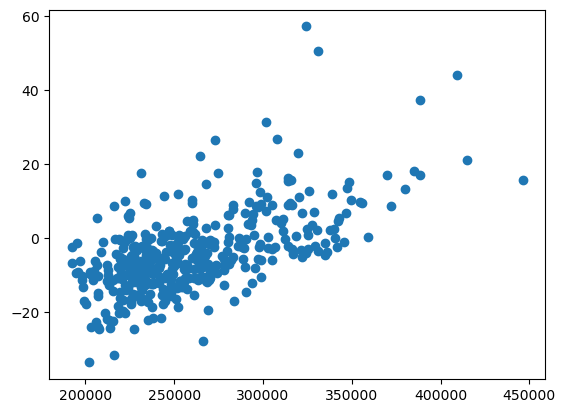

In [34]:
plt.scatter(x=y_test.values, y=error.values)

In [35]:
print("Average Absolute Error is", abs(error).mean())
print("Average Price is", x_test["price"].values.mean())
print("Average Error is ",abs(error).mean()/x_test["price"].values.mean()*100)

Average Absolute Error is 8.880165936803722
Average Price is 27.83127443150796
Average Error is  31.907148049068248
